In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.preprocessing import StandardScaler


train = pd.read_csv('data/single_turbine_data/train_reduced_unskewed.csv')
test = pd.read_csv('data/single_turbine_data/test_reduced_unskewed.csv')

train['# Date and time'] = pd.to_datetime(train['# Date and time'])
test['# Date and time'] = pd.to_datetime(test['# Date and time'])

train.set_index('# Date and time', inplace=True)
test.set_index('# Date and time', inplace=True)

label = ['1_Gear oil temperature (°C)']

X_train = train.drop(label, axis=1)
y_train = train[label]
X_test = test.drop(label, axis=1)
y_test = test[label]

original_cols = ['1_Power (kW)',
       '1_Front bearing temperature (°C)', '1_Transformer temperature (°C)',
       '1_Generator bearing rear temperature (°C)']

features = original_cols
X_test = X_test[features]
X_train = X_train[features]
y_test.index = X_test.index
y_train.index = X_train.index

# Scaling
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_Y.fit_transform(y_train)
y_test = scaler_Y.transform(y_test)

# dataset and dataloader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np

# device = torch.device('mps')

# Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


mps_device = torch.device("mps")

X_train = torch.tensor(X_train, dtype=torch.float32).to(mps_device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(mps_device)


# Model Architecture
class TimeSeriesModel(nn.Module):
    def __init__(self):
        super(TimeSeriesModel, self).__init__()
        self.transformer = nn.Transformer(d_model=2, nhead=1, num_encoder_layers=2)
        self.fc1 = nn.Linear(2, 10)
        self.fc2 = nn.Linear(10, 1)
        
    def forward(self, x):
        x = self.transformer(x, x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


In [ ]:

# Initialize Model, Loss, Optimizer
# model = TimeSeriesModel().to(mps_device)
# criterion = nn.MSELoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training Loop
# for epoch in range(100):
#     optimizer.zero_grad()
#     output = model(X_train)
#     loss = criterion(output, y_train)
#     loss.backward()
#     optimizer.step()
#     print(f'Epoch {epoch+1}, Loss: {loss.item()}')

In [6]:
class ResidualBiGRU(nn.Module):
    def __init__(self, hidden_size, n_layers=1, bidir=True):
        super(ResidualBiGRU, self).__init__()

        self.hidden_size = hidden_size
        self.n_layers = n_layers

        self.gru = nn.GRU(
            hidden_size,
            hidden_size,
            n_layers,
            batch_first=True,
            bidirectional=bidir,
        )
        dir_factor = 2 if bidir else 1
        self.fc1 = nn.Linear(
            hidden_size * dir_factor, hidden_size * dir_factor * 2
        )
        self.ln1 = nn.LayerNorm(hidden_size * dir_factor * 2)
        self.fc2 = nn.Linear(hidden_size * dir_factor * 2, hidden_size)
        self.ln2 = nn.LayerNorm(hidden_size)

    def forward(self, x, h=None):
        res, new_h = self.gru(x, h)
        # res.shape = (batch_size, sequence_size, 2*hidden_size)

        res = self.fc1(res)
        res = self.ln1(res)
        res = nn.functional.relu(res)

        res = self.fc2(res)
        res = self.ln2(res)
        res = nn.functional.relu(res)

        # skip connection
        res = res + x

        return res, new_h

class MultiResidualBiGRU(nn.Module):
    def __init__(self, input_size, hidden_size, out_size, n_layers, bidir=True):
        super(MultiResidualBiGRU, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.n_layers = n_layers

        self.fc_in = nn.Linear(input_size, hidden_size)
        self.ln = nn.LayerNorm(hidden_size)
        self.res_bigrus = nn.ModuleList(
            [
                ResidualBiGRU(hidden_size, n_layers=1, bidir=bidir)
                for _ in range(n_layers)
            ]
        )
        self.fc_out = nn.Linear(hidden_size, out_size)

    def forward(self, x, h=None):
        # if we are at the beginning of a sequence (no hidden state)
        if h is None:
            # (re)initialize the hidden state
            h = [None for _ in range(self.n_layers)]

        x = self.fc_in(x)
        x = self.ln(x)
        x = nn.functional.relu(x)

        new_h = []
        for i, res_bigru in enumerate(self.res_bigrus):
            x, new_hi = res_bigru(x, h[i])
            new_h.append(new_hi)

        x = self.fc_out(x)

        return x, new_h  # log probabilities + hidden states


In [7]:
# Initialize Model, Loss, Optimizer
input_size = 4  # Number of features
hidden_size = 32  # Hyperparameter, you can choose your value
out_size = 1  # We're predicting a single value
n_layers = 3  # Number of stacked Residual BiGRUs

model = MultiResidualBiGRU(input_size, hidden_size, out_size, n_layers).to(mps_device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Create DataLoader
train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=False)

losses = []
# Training Loop
for epoch in range(100):
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output, _ = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
    losses.append(loss.item())
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 0.027892492711544037
Epoch 2, Loss: 0.02147013694047928
Epoch 3, Loss: 0.025031540542840958
Epoch 4, Loss: 0.06758995354175568
Epoch 5, Loss: 0.034730106592178345
Epoch 6, Loss: 0.03522581607103348
Epoch 7, Loss: 0.03658449277281761
Epoch 8, Loss: 0.03717096522450447
Epoch 9, Loss: 0.037450361996889114
Epoch 10, Loss: 0.037338193506002426
Epoch 11, Loss: 0.037092726677656174
Epoch 12, Loss: 0.038074392825365067
Epoch 13, Loss: 0.041455067694187164
Epoch 14, Loss: 0.04216212034225464
Epoch 15, Loss: 0.04590974375605583
Epoch 16, Loss: 0.04191352799534798
Epoch 17, Loss: 0.036010656505823135
Epoch 18, Loss: 0.03895936906337738
Epoch 19, Loss: 0.035038262605667114
Epoch 20, Loss: 0.035958584398031235
Epoch 21, Loss: 0.08015439659357071
Epoch 22, Loss: 0.08999021351337433
Epoch 23, Loss: 0.09005457162857056
Epoch 24, Loss: 0.08921319246292114


KeyboardInterrupt: 

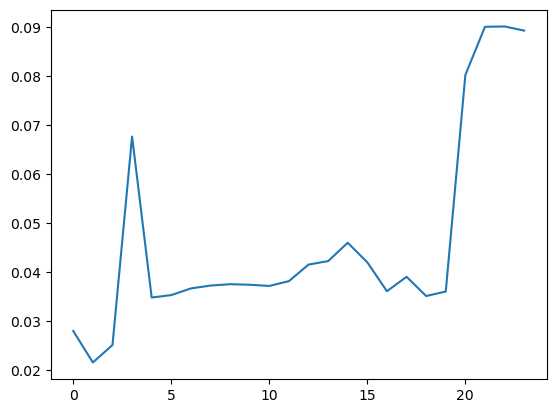

In [8]:
import matplotlib.pyplot as plt

plt.plot(range(len(losses)), losses)

In [ ]:
# unscale predictions
y_pred = output.detach().cpu().numpy()
y_pred = scaler.inverse_transform(y_pred)